<h1 style="font-weight: 700; font-size: 36px;">
    Building model and choosing the best one
</h1>
<div style="font-weight: 400; font-size: 18px;">

Task: 02_Modelling_and_Selection

Author: Dominik

The data is now clean and standardized. In this stage, I’ll be testing a few different approaches, starting with standard Linear Regression and moving into Lasso and Ridge. I will also use RFE and RFECV to use only the most important features.



</div>

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error, r2_score

In [22]:
df = pd.read_csv('../data/bodyfat_processed.csv')


X = df.drop(columns=['class'])    #'class' column is bodyfat
y = df['class']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Dataset loaded. Training set size: {X_train_scaled.shape}")

Dataset loaded. Training set size: (200, 13)


<div style="font-weight: 400; font-size: 18px;">

I’m splitting the data into an 80/20 train-test split.

The idea is to keep 20% of the people in this dataset as a "final exam" for the model. I’m also setting a random_state so that if I run this again, the results stay consistent. It's better to do the split now, before scaling so there's zero chance of the test data "leaking" into the training process.


I'm  also using RobustScaler here. From the EDA in Notebook 01, we saw about 20 outliers that could really mess with a standard scaler.

RobustScaler focuses on the median and the interquartile range (IQR), so it doesn't get distorted by extremal outliers.



</div>

In [23]:
#Linear regression with all the features results
model_basic=LinearRegression()
model_basic.fit(X_train_scaled, y_train)
Results=model_basic.predict(X_test_scaled)
print("\nModel Performance Metrics")
print(f"R2 Score: {r2_score(y_test, Results):.4f}")
print(f"MAE: {mean_absolute_error(y_test, Results):.2f}% body fat")


Model Performance Metrics
R2 Score: 0.5981
MAE: 3.81% body fat


<div style="font-weight: 400; font-size: 18px;">

Baseline Model: Using all available features to establish a performance benchmark before starting feature selection.
I use MAE instead of MSE because it's easier for human to interprete


</div>

The 5 best predictors are:
['Weight', 'Chest', 'Abdomen', 'Biceps', 'Wrist']


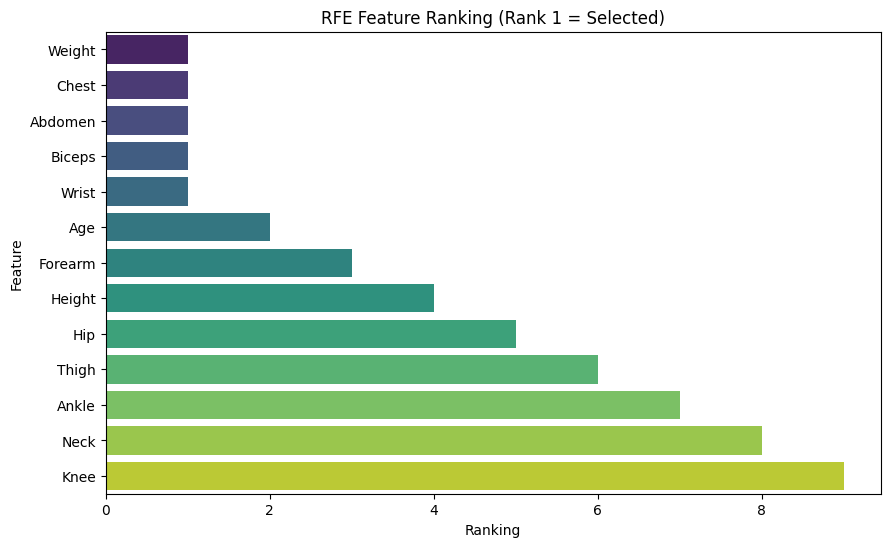

In [24]:
# Manual Feature Selection (RFE)

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression


lr = LinearRegression()

# initializing RFE
# n_features_to_select=5 tells the computer to stop when it finds the best 5
rfe = RFE(estimator=lr, n_features_to_select=5)

# fitting RFE on the SCALED training data
rfe.fit(X_train_scaled, y_train)

# extracting the results
selected_features = X.columns[rfe.support_]
feature_ranking = pd.DataFrame({'Feature': X.columns, 'Ranking': rfe.ranking_})

print("The 5 best predictors are:")
print(selected_features.tolist())


# Sort features by ranking (Rank 1 means it was selected)
feature_ranking = feature_ranking.sort_values(by='Ranking')

plt.figure(figsize=(10, 6))
sns.barplot(x='Ranking', y='Feature', data=feature_ranking,hue='Feature', palette='viridis')
plt.title("RFE Feature Ranking (Rank 1 = Selected)")
plt.show()

<div style="font-weight: 400; font-size: 18px;">
I’m using Recursive Feature Elimination (RFE) to strip this down to the Top 5 predictors. The goal is to see which features are actually  the most important factors of bf and which ones are just noise.

It works by backwards elimination, basically auditioning the features and cutting the weakest ones one by one until only the strongest 5 remain. This makes the model faster, simpler, and less likely to overfit


On the plot the rank 1 features are finalists, while the higher ranks show the order in which less useful measurements were filtered out of the model.


</div>




In [25]:
# training a simple model on just the 5 selected features to get their weights

X_train_rfe = X_train_scaled[:, rfe.support_]
X_test_rfe = X_test_scaled[:, rfe.support_]

lr_final = LinearRegression()
lr_final.fit(X_train_rfe, y_train)

y_pred = lr_final.predict(X_test_rfe)

# creating a DataFrame for the coefficients
coef_df = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': lr_final.coef_
})


coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Coefficients for the Top 5 Features:")
print(coef_df[['Feature', 'Abs_Coefficient']])

print("\nModel Performance Metrics")
print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}% body fat")

Coefficients for the Top 5 Features:
   Feature  Abs_Coefficient
2  Abdomen        15.309540
0   Weight         4.694536
4    Wrist         1.699305
3   Biceps         1.364038
1    Chest         0.953129

Model Performance Metrics
R2 Score: 0.5953
MAE: 3.80% body fat


<div style="font-weight: 400; font-size: 18px;">
I'm re-running the model using only the 5 selected features. This tells me exactly how much "weight" each measurement carries and, more importantly, if we can still predict body fat accurately after throwing away the rest of the noise.


The metrics are almost identical to the baseline model, but we are using significantly fewer features, which is much more practical for real-world application.
<div/>

Optimal number of features: 2
The best features are: ['Weight', 'Abdomen']
RFECV Performance
Optimal Features: 2

Model Performance Metrics
R2 Score: 0.6075
MAE: 3.7413% body fat


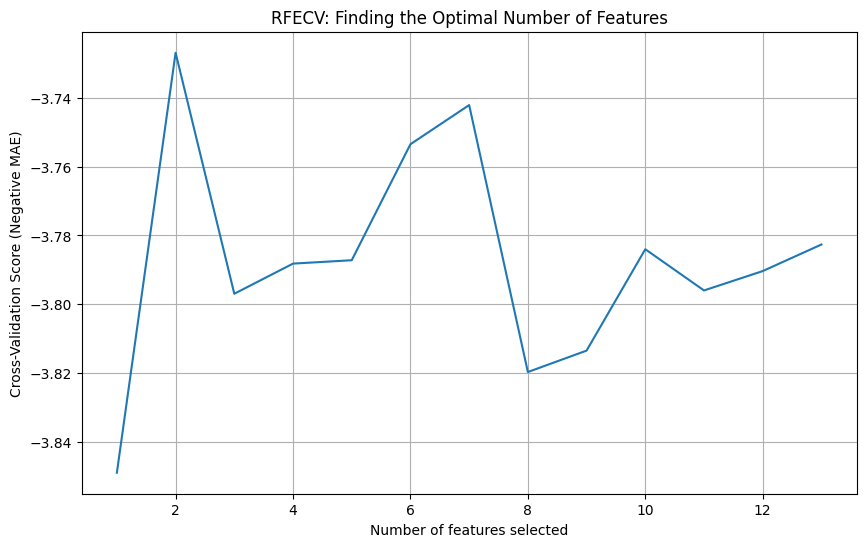

In [26]:
# Automated Feature Selection (RFECV)
from sklearn.feature_selection import RFECV

# initializing the selector
# cv=5 means 5-fold cross-validation,
# step=1 means one column drops every iteration
# scoring='neg_mean_absolute_error' means we want to minimize the prediction error
selector = RFECV(estimator=lr, step=1, cv=5, scoring='neg_mean_absolute_error')

# fit to the scaled data, using 5 fold cross valiadation
selector.fit(X_train_scaled, y_train)

X_test_selected = selector.transform(X_test_scaled)
X_train_selected = selector.transform(X_train_scaled)
y_pred_cv = selector.predict(X_test_scaled)

r2_cv = r2_score(y_test, y_pred_cv)
mse_cv = mean_absolute_error(y_test, y_pred_cv)

# Results
print(f"Optimal number of features: {selector.n_features_}")
print(f"The best features are: {X.columns[selector.support_].tolist()}")

print(f"RFECV Performance")
print(f"Optimal Features: {selector.n_features_}")

print("\nModel Performance Metrics")
print(f"R2 Score:{r2_cv: .4f}")
print(f"MAE: {mse_cv:.4f}% body fat")

plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross-Validation Score (Negative MAE)")
plt.plot(range(1, len(selector.cv_results_['mean_test_score']) + 1), 
         selector.cv_results_['mean_test_score'])
plt.title("RFECV: Finding the Optimal Number of Features")
plt.grid(True)
plt.show()

<div style="font-weight: 400; font-size: 18px;">
I am using RFECV to let the data tell me exactly how many features are optimal. By using 5-fold cross-validation, the model proves which combination of measurements yields the lowest error consistently, ensuring we don't include extra variables that add noise instead of value.
<div/>    
    We can see that using only the 2 best variables, our R² score improved and MAE dropped by about 0.6%
    

Full Feature Ranking (Rank 1 = Best):
Feature  Ranking
 Weight        1
Abdomen        1
  Wrist        2
 Biceps        3
  Chest        4
    Age        5
Forearm        6
 Height        7
    Hip        8
  Thigh        9
  Ankle       10
   Neck       11
   Knee       12


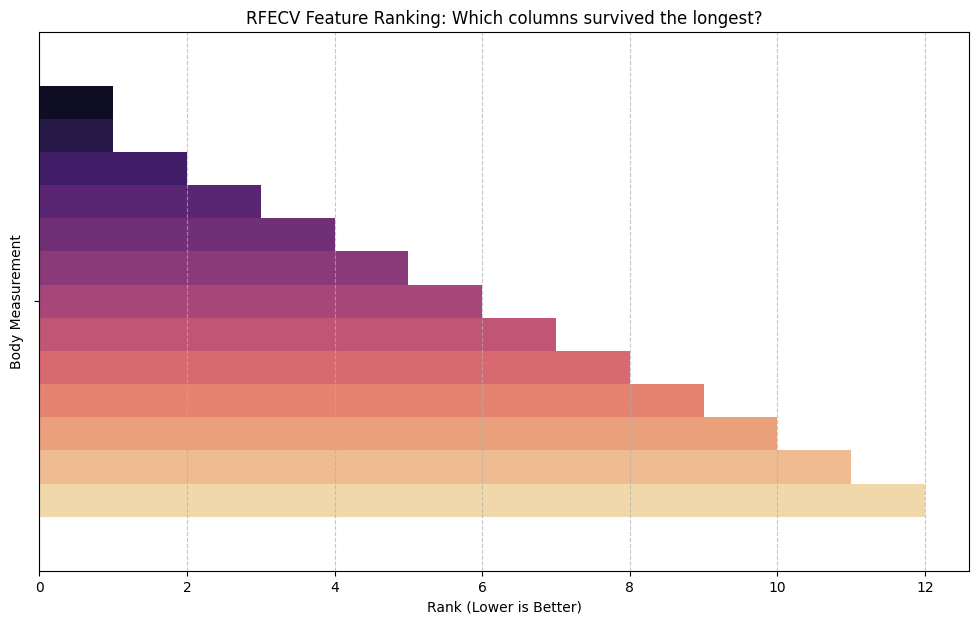

In [27]:
# checking the ranking table of every feature
ranking_df = pd.DataFrame({
    'Feature': X.columns,
    'Ranking': selector.ranking_
})

# sorting the features so Rank 1 is at the top
ranking_df = ranking_df.sort_values(by='Ranking')

# displaying
print("Full Feature Ranking (Rank 1 = Best):")
print(ranking_df.to_string(index=False))


plt.figure(figsize=(12, 7))
sns.barplot(x='Ranking', hue='Feature', data=ranking_df, palette='magma', legend=False)
plt.title("RFECV Feature Ranking: Which columns survived the longest?")
plt.xlabel("Rank (Lower is Better)")
plt.ylabel("Body Measurement")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

<div style="font-weight: 400; font-size: 18px;">
Here we can clearly see which columns are the most important. It is quite interesting that variables which, at first, seemed to be strongly correlated with body fat, like hip or chest, turned out to be less important.
This happens because in machine learning, high correlation with the target does not always mean high predictive power, some variables may carry redundant information or be overshadowed by more informative features in the model.

In [28]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_absolute_error, r2_score

# preparing the data using only the ranked features from RFECV
X_train_final = X_train_scaled[:, selector.support_]
X_test_final = X_test_scaled[:, selector.support_]

#alpha is the strength ot the penalty
models = {
    "Linear Regression": LinearRegression(),
    "Ridge (L2)": Ridge(alpha=1.0),
    "Lasso (L1)": Lasso(alpha=0.1)
}

# traing and evaluating in a loop
results = []

for name, model in models.items():
    model.fit(X_train_final, y_train)
    predictions = model.predict(X_test_final)
    
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    results.append({"Model": name, "MAE": mae, "R2": r2})

# 4. Display the Leaderboard
performance_df = pd.DataFrame(results).sort_values(by="MAE")
print("Model Comparison Leaderboard:")
print(performance_df)


Model Comparison Leaderboard:
               Model       MAE        R2
0  Linear Regression  3.741315  0.607458
1         Ridge (L2)  3.754403  0.606290
2         Lasso (L1)  3.811011  0.594896


<div style="font-weight: 400; font-size: 18px;">
I ran Ridge and Lasso alongside the Linear Regression just to see if a penalty would squeeze out any more accuracy. Normally, these models are lifesavers when you have dozens of messy columns, but since the RFECV already did the heavy lifting of cutting the "junk" (like Hip and Chest), there wasn't much left for them to do. The results ended up being almost identical. Because of that, I’m sticking with the standard Linear Regression. It’s simpler, easier to explain, and it doesn't add any unnecessary math "bias" when we only have two main features to worry about anyway.

In [29]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV

# candidate models
configs = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {} # No hyperparameters to tune for basic OLS
    },
    "Ridge": {
        "model": Ridge(),
        "params": {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
    },
    "Lasso": {
        "model": Lasso(),
        "params": {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
    }
}

best_models = {}

# the Tuning & Comparison Loop
for name, config in configs.items():
    grid = GridSearchCV(config['model'], config['params'], cv=5, scoring='neg_mean_absolute_error')
    grid.fit(X_train_final, y_train)
    
    best_models[name] = {
        "best_estimator": grid.best_estimator_,
        "best_score": -grid.best_score_
    }
    
    # print Alpha if it's not the Linear Regression model
    alpha_info = f", Best Alpha: {grid.best_params_.get('alpha')}" if 'alpha' in grid.best_params_ else ""
    print(f"{name} - CV MAE: {-grid.best_score_:.3f}{alpha_info}")


champion_name = min(best_models, key=lambda x: best_models[x]['best_score']) #model with minimal MAE
final_model = best_models[champion_name]['best_estimator']

print(f"\nThe Final Champion is: {champion_name}")

Linear Regression - CV MAE: 3.603
Ridge - CV MAE: 3.604, Best Alpha: 0.001
Lasso - CV MAE: 3.604, Best Alpha: 0.001

The Final Champion is: Linear Regression


<div style="font-weight: 400; font-size: 18px;">
I decided to run a GridSearchCV on all three models just to be 100% sure I wasn't leaving any accuracy on the table. By testing different Alpha values (the "strength" of the penalty) for Ridge and Lasso, I wanted to see if a specific tuning could beat the basic Linear Regression. As it turns out, the scores didn't really budge. Since we only have a few high-quality features left after RFECV, the models are all basically reaching the same conclusion. Even with the "optimal" settings, the standard Linear Regression is just as good as the more complex ones. It proves that for this specific dataset, keeping it simple is the most professional move.

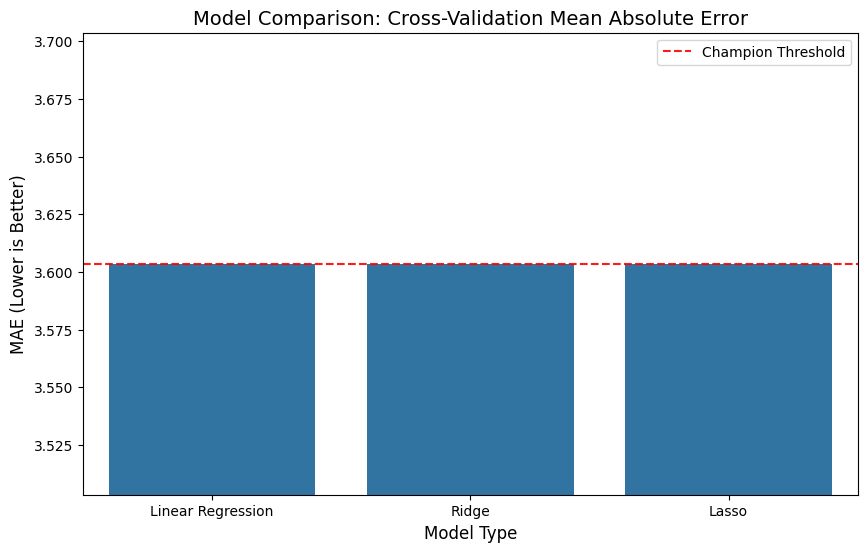

In [30]:
#data for plotting
model_names = list(best_models.keys())
mae_scores = [best_models[name]['best_score'] for name in model_names]


plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=mae_scores)
plt.axhline(y=min(mae_scores), color='red', linestyle='--', alpha=0.9, label='Champion Threshold')
plt.ylim(min(mae_scores) - 0.1, max(mae_scores) + 0.1)
plt.title('Model Comparison: Cross-Validation Mean Absolute Error', fontsize=14)
plt.ylabel('MAE (Lower is Better)', fontsize=12)
plt.xlabel('Model Type', fontsize=12)
plt.legend()
plt.show()

<div style="font-weight: 400; font-size: 18px;">
The bar chart confirms what we suspected: after tuning the hyperparameters, all three models perform almost identically. Whether we use a simple linear approach or a more complex regularized one (Ridge/Lasso), the MAE stays locked in at the same level. This is actually a great sign—it means our feature selection was so effective that the specific choice of a linear algorithm doesn't change the outcome much. The "Champion" is essentially a tie, so we stick with the simplest version for the final project.

In [32]:
from sklearn.metrics import mean_absolute_error, r2_score

# predictions on the unseen test data
y_pred = final_model.predict(X_test_final)

# final metrics
final_mae = mean_absolute_error(y_test, y_pred)
final_r2 = r2_score(y_test, y_pred)

print(f"--- FINAL CHAMPION EVALUATION ({champion_name}) ---")
print(f"Final Test MAE: {final_mae:.3f}")
print(f"Final Test R2: {final_r2:.3f}")

--- FINAL CHAMPION EVALUATION (Linear Regression) ---
Final Test MAE: 3.741
Final Test R2: 0.607


<div style="font-weight: 400; font-size: 18px;">
The "Champion" model was tested on unseen data to see how it performs in the real world. The results are solid:

    MAE (3,741): The model is typically off by only 3,74 percentage points.

    R2 (0.607): We are capturing 60,7% of the factors that determine body fat using just two measurements.
<div style="font-weight: 400; font-size: 18px;">
The fact that these numbers match our training scores proves the model is stable and not just "lucky." It’s a reliable, simple tool that works without being over-complicated.

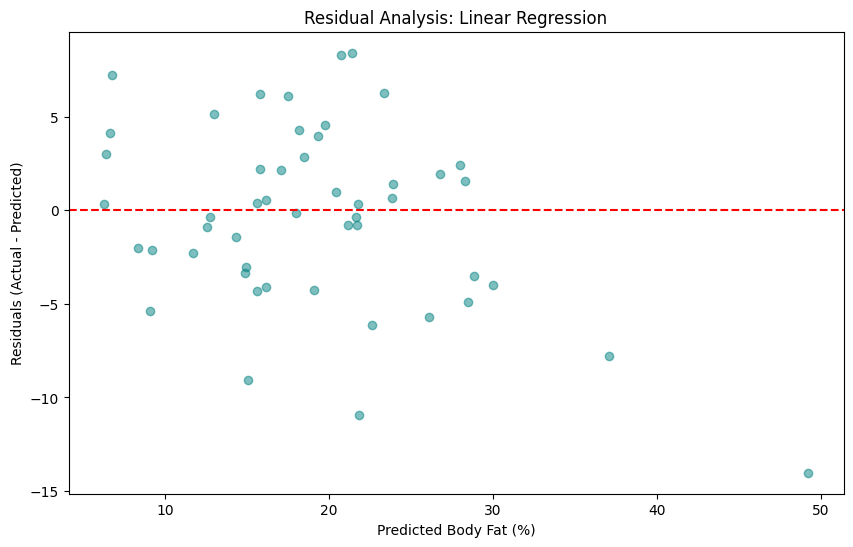

In [33]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5, color='teal')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Body Fat (%)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'Residual Analysis: {champion_name}')
plt.show()

<div style="font-weight: 400; font-size: 18px;">
This plot is basically a "honesty check" for the model. I’m looking at the gaps between what the model guessed and what the real numbers were. What we want to see is just a random cloud of dots, and that’s exactly what we have here. There’s no weird "U" shape or "cone" pattern, which tells me the linear model isn't biased. It isn't getting "confused" by very high or very low body fat percentages; it's making the same small, random errors across the board. The few dots drifting far from the red line are just outliers (people with unusual body types), not a sign that the model is broken.

In [34]:
# best features from selector
best_features = X.columns[selector.support_].tolist()

# Refit the scaler on ONLY the best features 

scaler = RobustScaler()
X_train_best = X_train[best_features]# only the columns the model uses
scaler.fit(X_train_best) 

def predict_bodyfat_pro(measurements_dict, model, fitted_scaler, feature_names):
    # input to DataFrame
    input_df = pd.DataFrame([measurements_dict])
    
    # reordering columns to ensure they match the 'best_features' list
    input_df = input_df[feature_names]
    
    # transforming using the scaler that now only expects these specific columns
    input_scaled = fitted_scaler.transform(input_df)
    
    # predict using the champion model
    prediction = model.predict(input_scaled)
    return prediction[0]

# test
sample_input = {feat: X[feat].mean() for feat in best_features}
result = predict_bodyfat_pro(sample_input, final_model, scaler, best_features)

print(f"✅ Success! Predicted Body Fat: {result:.2f}%")

✅ Success! Predicted Body Fat: 19.24%


<div style="font-weight: 400; font-size: 18px;">
This is where the project finally turns into a real tool. I wrote a function that takes raw measurements and turns them into a body fat percentage.

A key professional detail here: I re-aligned the scaler to only care about the "Top 2" features. This prevents the model from getting confused by the 13 other columns we already tossed out. Seeing it work on a "sample person" makes it feel less like a math experiment and more like a tool you could actually use in a real app.

In [35]:
import joblib
import os


# '..' means "go up one level" out of the notebooks folder
models_dir = os.path.join('..', 'models')

# create the directory if it doesn't exist
os.makedirs(models_dir, exist_ok=True)

# save the 3 essential components using the full path
joblib.dump(final_model, os.path.join(models_dir, 'bodyfat_model.pkl'))
joblib.dump(scaler, os.path.join(models_dir, 'scaler.pkl'))
joblib.dump(best_features, os.path.join(models_dir, 'features.pkl'))

print(f"✅ Success! Files saved to: {os.path.abspath(models_dir)}")

✅ Success! Files saved to: /home/dw/Desktop/bodyfat_ml_project/models


<div style="font-weight: 400; font-size: 18px;">
This is the final step: packaging everything up so it can be used outside of this notebook. I’m saving the model, the scaler, and the feature list as files.

I can now just load these files into any website or app, and they’ll be ready to work instantly. By putting them in a dedicated folder, I’m keeping the project organized and professional for future use. They will be used in main.py for body fat estimating.